# Spaceship Titanic

## Which passengers were transported to another dimension?

In this lab, we will predict which passengers were transported to another dimension during the Spaceship Titanic's collision with the spacetime anomaly. 

#### Dataset description

- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Outline
...


## 1. Packages

First, let's run the cell below to import all the packages that we will need during this assignment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost.utils import get_confusion_matrix

## 2. Viewing The Data

Taking a look in our training dataset and getting more familiar with it. Remember that the training dataset and test dataset are already separated.

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Looking at the first five examples of the dataset.

In [3]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Seeing the shape of our dataset.

In [4]:
n_rows = df_train.shape[0]
n_columns = df_train.shape[1]

print(f"The number of rows is: {n_rows}")
print(f"The number of columns is: {n_columns}")

The number of rows is: 8693
The number of columns is: 14


In [5]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Checking if the dataframe has some null value.

In [6]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Notice that we have some columns with null values, then, posteriorly, we have we will have to treat these columns.

#### Summary of each categorical feature

In [7]:
df_train.describe(include=object)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


#### Summary measures of each numerical feature

In [8]:
df_train.describe(include=[int, float])

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## 3. Exploratory Analysis

### 3.1. Viewing our `target`

Our target is the column `Transported`, which tell us if a passenger were transported to another dimension or not. We can see that with the values of this column, that are:

- `False`: The passenger were not transported.
- `True`: The passenger were transported.

Let's take a look in the proportion of the values.

In [9]:
df_train['Transported'].value_counts(normalize=True).round(3)

True     0.504
False    0.496
Name: Transported, dtype: float64

That is great, this showns that the proportion between the two possibilities it's practically the same. This mean that the dataset is balanced, which avoids **overffiting**, is able to **not overestimate performance and generalize more**.

### 3.2.  Bar relations

Let's try verify some relations that the others columns have with our target.

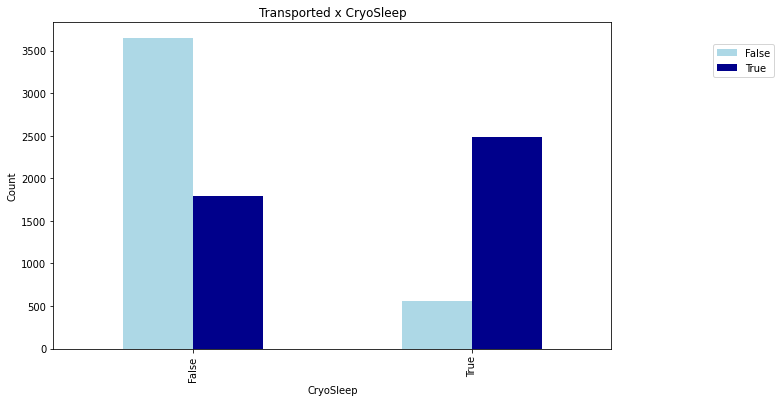

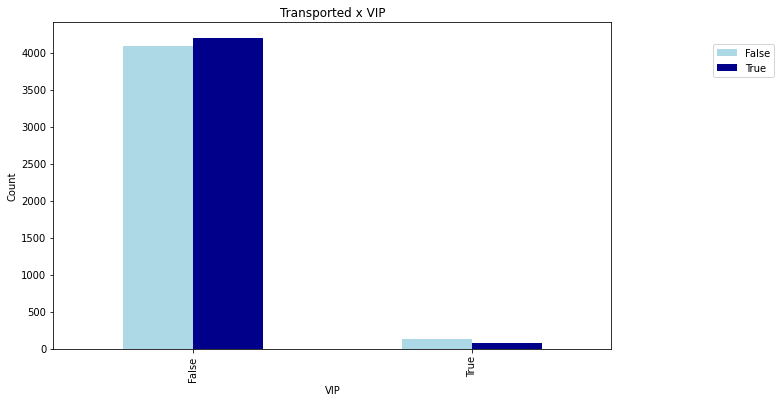

In [10]:
# ploting bar of CryoSleep and VIP (only two values)
colors1 = ['lightblue','darkblue']

relation = pd.crosstab(df_train['CryoSleep'], df_train['Transported'])
relation.plot.bar(color = colors1, figsize=(10,6))
plt.ylabel('Count')
plt.legend(loc='center')
plt.legend(bbox_to_anchor=(1.3, 0.95)); # Coloca legenda para fora da janela gráfica
plt.title('Transported x CryoSleep')
plt.show()

relation = pd.crosstab(df_train['VIP'], df_train['Transported'])
relation.plot.bar(color = colors1, figsize=(10,6))
plt.ylabel('Count')
plt.legend(loc='center')
plt.legend(bbox_to_anchor=(1.3, 0.95)); # Coloca legenda para fora da janela gráfica
plt.title('Transported x VIP')
plt.show()

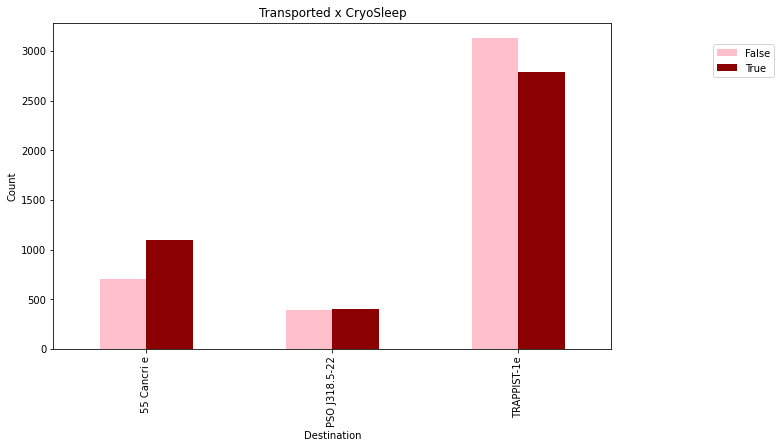

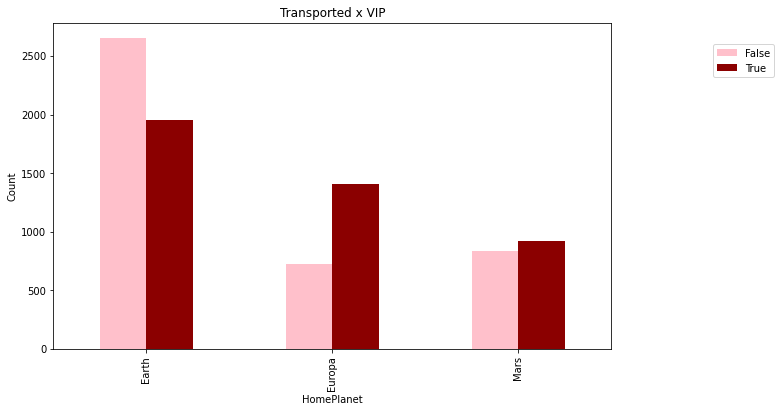

In [11]:
# ploting bar of CryoSleep and VIP (only three values)
colors2 = ['pink','darkred']

relation = pd.crosstab(df_train['Destination'], df_train['Transported'])
relation.plot.bar(color = colors2, figsize=(10,6))
plt.ylabel('Count')
plt.legend(loc='center')
plt.legend(bbox_to_anchor=(1.3, 0.95)); # Coloca legenda para fora da janela gráfica
plt.title('Transported x CryoSleep')
plt.show()

relation = pd.crosstab(df_train['HomePlanet'], df_train['Transported'])
relation.plot.bar(color = colors2, figsize=(10,6))
plt.ylabel('Count')
plt.legend(loc='center')
plt.legend(bbox_to_anchor=(1.3, 0.95)); # Coloca legenda para fora da janela gráfica
plt.title('Transported x VIP')
plt.show()

### 3.3. Boxplot's

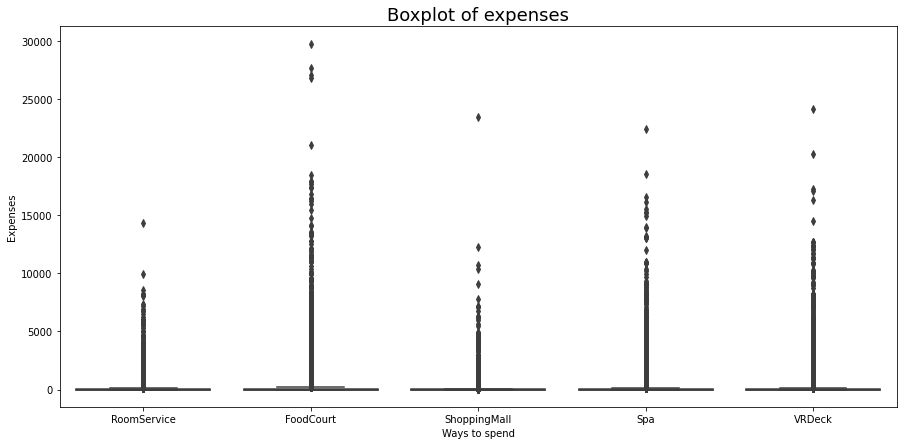

In [12]:
# taking numerical columns without age 
num_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numerical = df_train.loc[:, num_columns]

# figure size
plt.figure(figsize=(15, 7))

# Create simultaneous boxplot with Seaborn
sns.boxplot(data=numerical)
plt.xlabel('Ways to spend')
plt.ylabel('Expenses')
plt.title('Boxplot of expenses',loc="center", fontsize=18)

# Show the figure
plt.show()

Although we observe that there are extreme and different values in each of the types of expenses, we can say that these values **make sense**, since:

- For example, by bar graphs, in this case in relation to "Transported x VIP", the overwhelming majority does not adhere to the VIP service, which can demonstrate that **the vast majority either do not need or are not able to pay for it**.

- If we analyze the bar graph of "Transported x CryoSleep", a reasonable proportion of people were placed in cryogenic cabins, which we can **infer that basically people in a cryogenic state will not have expenses during the trip**.


Thus, it is really intuitive that these values ​​make sense, since the vast majority are not interested in, do not need or cannot pay for the VIP service, in addition to the fact that a reasonable number of passengers are in a cryogenic state.


therefore, we **will not** remove the outliers.

## 4. Feature Engineering

### 4.1. Column "Surname"

We can observe that passengers of the same group, tends to have the same last name. So, we will create the column "Surname" for keep this information.

In [13]:
df_train['Surname'] = df_train.loc[df_train['Name'].notnull(), 'Name'].apply(lambda x: x.split()[1])

### 4.2. Column "GroupNumber"

Let's assume that for the sake of simplification, the part that really contains important information is just the number that refers to the group with which the passenger is traveling in `PassengerId`.  If you noticed too, **there are no null values** ​​for the `PassengerId` column, which can help filtering out null values.

In [14]:
df_train['GroupNumber'] = df_train.PassengerId.str.split('_').str[0].astype(int)

### 4.3. Column "TotalSpend"

This column will keep the sum of all expenses of each passenger.

In [15]:
df_train['TotalSpend'] = df_train[num_columns].sum(axis=1)

# Assume that if passenger didn't spend any money in non-missing expense columns then he popably didn't in a missing columns (most often there is only 1 column missing so propability of that is high)
df_train.loc[df_train['TotalSpend'] == 0, num_columns] = 0

## 5. Treatment of Null Values

Firstly, let's fill missing values of `Cabin`, `Surname`, `HomePlanet` and `Destination` based on `GroupNumber`. We will assume that passengers in one room have the same cabin, destination, surname and home planet.

In [16]:
room_related_columns = ['Cabin', 'Surname', 'Destination', 'HomePlanet']

for col in room_related_columns:
    room_to_col = df_train[['GroupNumber', col]].dropna().groupby('GroupNumber')[col].apply(lambda x: x.mode()[0]) # without dropna mode for single person rooms with nan col would be empty and mode()[0] will raise an error
    df_train[col] = df_train.apply(lambda row: room_to_col[row['GroupNumber']] if pd.isna(row[col]) and row['GroupNumber'] in room_to_col.index else row[col], axis=1)
    df_train[col] = df_train.groupby('GroupNumber')[col].ffill().bfill()

Let's split the column `Cabin` in 3 new columns:

- `CabDeck`
- `CabNum`
- `CabSide`

In [17]:
df_train[['CabDeck', 'CabNum', 'CabSide']] = df_train['Cabin'].str.split('/', expand=True)

# After Cabin split, CabNumber is a object type column so we will convert it to int 
df_train['CabNum'] = pd.to_numeric(df_train['CabNum']).astype(int)

Now, remembering the intuition acquired in 3.3., let's consider 3 cases:

- If the passenger is in a cryogenic sleep, his total spending should be 0 and any expense.

- If the passenger has spent a certain amount of money, then he is not in cryogenic sleep.

- If the passenger has not spent, then he will most likely be in cryogenic sleep.

In [18]:
# first case
df_train.loc[df_train['CryoSleep'] == True, ['TotalSpend'] + num_columns] = 0

# second case
df_train.loc[(df_train['CryoSleep'].isnull()) & (df_train['TotalSpend'] > 0), 'CryoSleep'] = False

# third case 
df_train.loc[(df_train['CryoSleep'].isnull()) & (df_train['TotalSpend'] == 0), 'CryoSleep'] = True

**Drop Columns**

Now that we've managed to extract important information, the `Name` and `Cabin` columns are no longer relevant. Let's drop them.

In [19]:
df_train.drop(columns=['Cabin', 'Name'], inplace=True)

Let's see which null values still have.

In [20]:
df_train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age             179
VIP             203
RoomService     103
FoodCourt       102
ShoppingMall    100
Spa             112
VRDeck          102
Transported       0
Surname           0
GroupNumber       0
TotalSpend        0
CabDeck           0
CabNum            0
CabSide           0
dtype: int64

Apparently, what's left is to filter out null values ​​from numeric columns.


## 6. Data Preprocessing

### 6.1. Spliting the dataframe `df_train` in `X` and `y` dataframes.

In [21]:
X = df_train.drop(columns='Transported', inplace=False)
y = df_train.loc[:, 'Transported']

### 6.2. Pre-processing numerical data

**Numerical columns**
- `StandardImputer()` fills missing values with mean
- `QuantileTransformer()` is used so the data follows normal distribution
- `StandartScaler()` normalizes the data, mean = 0, std = 1


First, let's start separating the numerical features of our `X` dataframe.

In [22]:
numerical_features = []
for column in X.columns:
    if X[column].dtypes == 'float64' or X[column].dtypes == 'int32':
        numerical_features.append(column)

df_num = X.loc[:, numerical_features]

With the `SimpleImputer`, let's fill the missing values by the strategy `mean`.

In [23]:
# Create a instance of SimpleImputer with strategy of mean
imputer = SimpleImputer(strategy='mean')

# Apply the SimpleImputer
df_impute = imputer.fit_transform(df_num)

Now, we will make the features follow a normal distribution with the transformer `QuantileTransformer`.

In [24]:
# Create a instance of QuantileTransformer
transformer = QuantileTransformer(output_distribution='normal', random_state=2137)

# Apply the QuantileTransformer to df_impute
df_transf = transformer.fit_transform(df_impute)

Finally, we will scale the values ​​obtained with `StandardScaler`.

In [25]:
# Create a instance of StandardScaler
scaler = StandardScaler()

# apply the StandardScaler to df_transf
df_scaler = scaler.fit_transform(df_transf)

In [26]:
df_num = pd.DataFrame(df_scaler, columns=numerical_features)

In [27]:
df_num.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNumber,TotalSpend,CabNum
0,0.687314,-0.728833,-0.750479,-0.721543,-0.776926,-0.742384,-5.184648,-1.158301,-5.099170
1,-0.161416,1.251290,1.134122,1.231545,1.309369,1.201219,-3.606217,0.621619,-5.099170
2,1.549540,1.218752,1.569770,-0.721543,1.765332,1.204310,-3.423109,1.309495,-5.099170
3,0.401203,-0.728833,1.426241,1.383480,1.598274,1.266890,-3.423109,1.113858,-5.099170
4,-0.814420,1.319495,1.188760,1.309119,1.314234,1.123672,-3.311901,0.782533,-2.692718


### 6.3. Pre-processing categorical data

**Categorical columns**
- `StandardImputer()` fills missing values with most frequent ones
- `OneHotEncoder()` one-hot encodes the data
- Categorical one-hot encoded columns are already binary so performing `QuantileTransformer()` and `StandartScaler()` won't change much

First, let's start separating the numerical features of our `X` dataframe.

In [28]:
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabDeck', 'CabSide']

df_cat = X.loc[:, categorical_features]

With the `SimpleImputer`, let's fill the missing values by the strategy `most_frequenty`.

In [29]:
# Create a instance of SimpleImputer with the strategy of "most_frequent"
imputer_cat = SimpleImputer(strategy='most_frequent')

# Apply the SimpleImputer to categorical data
df_cat_imput = imputer_cat.fit_transform(df_cat)

# Convert the imputed data to a DataFrame
df_imput = pd.DataFrame(df_cat_imput, columns=categorical_features)

Now, we will apply the `OneHotEncoder` to impute data.

In [30]:
# Create a instance of OneHotEncoder
encoder = OneHotEncoder()

# Apply the OneHotEncoder to categorical impute data
df_cat_encoded = encoder.fit_transform(df_imput).toarray()

# Converter os dados one-hot encoded em um DataFrame
df_cat = pd.DataFrame(df_cat_encoded, columns=encoder.get_feature_names(categorical_features))

df_cat.head()

C:\Users\samue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,CabDeck_A,CabDeck_B,CabDeck_C,CabDeck_D,CabDeck_E,CabDeck_F,CabDeck_G,CabDeck_T,CabSide_P,CabSide_S
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


**Column `Surname`**


Despite being a categorical column, it is not binary, so we will use numeric column transformers

In [31]:
surname_col = df_train['Surname']

# Apply the SimpleImputer with the strategy 'most_frequent'
surn_imputer = SimpleImputer(strategy='most_frequent')
surname_coluna_imputado = surn_imputer.fit_transform(surname_col.values.reshape(-1, 1))

# Apply the OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
surname_col_encoded = encoder.fit_transform(surname_coluna_imputado)

# pd.Series
surname_series = pd.Series(surname_col_encoded.flatten())

### 6.4. Concatenating the dataframes

In [32]:
X_new = pd.concat([df_num, df_cat], axis=1)
X_new['Surname'] = surname_series
X_new.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNumber,TotalSpend,CabNum,HomePlanet_Earth,...,CabDeck_B,CabDeck_C,CabDeck_D,CabDeck_E,CabDeck_F,CabDeck_G,CabDeck_T,CabSide_P,CabSide_S,Surname
0,0.687314,-0.728833,-0.750479,-0.721543,-0.776926,-0.742384,-5.184648,-1.158301,-5.099170,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1431.0
1,-0.161416,1.251290,1.134122,1.231545,1.309369,1.201219,-3.606217,0.621619,-5.099170,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2109.0
2,1.549540,1.218752,1.569770,-0.721543,1.765332,1.204310,-3.423109,1.309495,-5.099170,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990.0
3,0.401203,-0.728833,1.426241,1.383480,1.598274,1.266890,-3.423109,1.113858,-5.099170,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990.0
4,-0.814420,1.319495,1.188760,1.309119,1.314234,1.123672,-3.311901,0.782533,-2.692718,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1778.0


## 7. Model Creation & Evaluation

### 7.1. Spliting the data

Let's split the training data and the validation data.

In [33]:
X_train, X_cv, y_train, y_cv = train_test_split(X_new, y, test_size=0.2, random_state=2137)

In [34]:
print("Dimension of X_train =>", X_train.shape)
print("Dimension of X_cv =>", X_cv.shape)
print("Dimension of y_train =>", y_train.shape)
print("Dimension of y_cv =>", y_cv.shape)

Dimension of X_train => (6954, 30)
Dimension of X_cv => (1739, 30)
Dimension of y_train => (6954,)
Dimension of y_cv => (1739,)


### 7.2. Models

For this problem, we will follow the performance of two models:

- `CatBoostClassifier`
- `A Neural Network with TF`

First, let's train both.

#### 7.2.1. CatBoostClassifier

In [35]:
# Create a instance of model CatBoostClassifier
model_CB = CatBoostClassifier()

# Train the model
model_CB.fit(X_train, y_train)

Learning rate set to 0.023581
0:	learn: 0.6836251	total: 137ms	remaining: 2m 16s
1:	learn: 0.6721664	total: 140ms	remaining: 1m 9s
2:	learn: 0.6612754	total: 143ms	remaining: 47.5s
3:	learn: 0.6520622	total: 146ms	remaining: 36.3s
4:	learn: 0.6427354	total: 149ms	remaining: 29.7s
5:	learn: 0.6340168	total: 152ms	remaining: 25.2s
6:	learn: 0.6264526	total: 156ms	remaining: 22.1s
7:	learn: 0.6184255	total: 158ms	remaining: 19.6s
8:	learn: 0.6104730	total: 161ms	remaining: 17.7s
9:	learn: 0.6020576	total: 164ms	remaining: 16.2s
10:	learn: 0.5943949	total: 166ms	remaining: 15s
11:	learn: 0.5879186	total: 169ms	remaining: 13.9s
12:	learn: 0.5822273	total: 172ms	remaining: 13s
13:	learn: 0.5769826	total: 174ms	remaining: 12.3s
14:	learn: 0.5709719	total: 177ms	remaining: 11.6s
15:	learn: 0.5656118	total: 180ms	remaining: 11.1s
16:	learn: 0.5611138	total: 184ms	remaining: 10.6s
17:	learn: 0.5572931	total: 187ms	remaining: 10.2s
18:	learn: 0.5534162	total: 190ms	remaining: 9.79s
19:	learn: 0.5

172:	learn: 0.3901647	total: 668ms	remaining: 3.19s
173:	learn: 0.3897116	total: 671ms	remaining: 3.19s
174:	learn: 0.3894292	total: 675ms	remaining: 3.18s
175:	learn: 0.3891074	total: 679ms	remaining: 3.18s
176:	learn: 0.3889311	total: 688ms	remaining: 3.2s
177:	learn: 0.3887310	total: 692ms	remaining: 3.2s
178:	learn: 0.3883813	total: 696ms	remaining: 3.19s
179:	learn: 0.3881316	total: 699ms	remaining: 3.19s
180:	learn: 0.3877714	total: 702ms	remaining: 3.18s
181:	learn: 0.3875269	total: 706ms	remaining: 3.17s
182:	learn: 0.3872206	total: 710ms	remaining: 3.17s
183:	learn: 0.3868157	total: 713ms	remaining: 3.16s
184:	learn: 0.3866894	total: 716ms	remaining: 3.16s
185:	learn: 0.3864303	total: 720ms	remaining: 3.15s
186:	learn: 0.3862575	total: 723ms	remaining: 3.14s
187:	learn: 0.3859753	total: 726ms	remaining: 3.14s
188:	learn: 0.3856663	total: 730ms	remaining: 3.13s
189:	learn: 0.3854378	total: 733ms	remaining: 3.13s
190:	learn: 0.3848547	total: 736ms	remaining: 3.12s
191:	learn: 0.

348:	learn: 0.3550108	total: 1.21s	remaining: 2.25s
349:	learn: 0.3548263	total: 1.21s	remaining: 2.24s
350:	learn: 0.3544655	total: 1.21s	remaining: 2.24s
351:	learn: 0.3543328	total: 1.22s	remaining: 2.24s
352:	learn: 0.3541668	total: 1.22s	remaining: 2.23s
353:	learn: 0.3539197	total: 1.22s	remaining: 2.23s
354:	learn: 0.3538096	total: 1.23s	remaining: 2.23s
355:	learn: 0.3536892	total: 1.23s	remaining: 2.22s
356:	learn: 0.3535019	total: 1.23s	remaining: 2.22s
357:	learn: 0.3533987	total: 1.23s	remaining: 2.21s
358:	learn: 0.3532965	total: 1.24s	remaining: 2.21s
359:	learn: 0.3530456	total: 1.24s	remaining: 2.21s
360:	learn: 0.3528445	total: 1.24s	remaining: 2.2s
361:	learn: 0.3525461	total: 1.25s	remaining: 2.2s
362:	learn: 0.3524307	total: 1.25s	remaining: 2.2s
363:	learn: 0.3522608	total: 1.25s	remaining: 2.19s
364:	learn: 0.3520126	total: 1.26s	remaining: 2.19s
365:	learn: 0.3519200	total: 1.26s	remaining: 2.19s
366:	learn: 0.3517558	total: 1.26s	remaining: 2.18s
367:	learn: 0.3

533:	learn: 0.3248244	total: 1.74s	remaining: 1.52s
534:	learn: 0.3246595	total: 1.75s	remaining: 1.52s
535:	learn: 0.3245220	total: 1.75s	remaining: 1.51s
536:	learn: 0.3243524	total: 1.75s	remaining: 1.51s
537:	learn: 0.3242614	total: 1.75s	remaining: 1.51s
538:	learn: 0.3240060	total: 1.76s	remaining: 1.5s
539:	learn: 0.3238252	total: 1.76s	remaining: 1.5s
540:	learn: 0.3236922	total: 1.76s	remaining: 1.5s
541:	learn: 0.3234517	total: 1.77s	remaining: 1.49s
542:	learn: 0.3233001	total: 1.77s	remaining: 1.49s
543:	learn: 0.3231846	total: 1.77s	remaining: 1.49s
544:	learn: 0.3229748	total: 1.77s	remaining: 1.48s
545:	learn: 0.3227917	total: 1.78s	remaining: 1.48s
546:	learn: 0.3226569	total: 1.78s	remaining: 1.47s
547:	learn: 0.3225110	total: 1.78s	remaining: 1.47s
548:	learn: 0.3224157	total: 1.78s	remaining: 1.47s
549:	learn: 0.3222553	total: 1.79s	remaining: 1.46s
550:	learn: 0.3220830	total: 1.79s	remaining: 1.46s
551:	learn: 0.3219832	total: 1.79s	remaining: 1.46s
552:	learn: 0.3

721:	learn: 0.2997820	total: 2.28s	remaining: 879ms
722:	learn: 0.2996642	total: 2.29s	remaining: 876ms
723:	learn: 0.2995822	total: 2.29s	remaining: 873ms
724:	learn: 0.2993889	total: 2.29s	remaining: 870ms
725:	learn: 0.2993361	total: 2.3s	remaining: 867ms
726:	learn: 0.2991528	total: 2.3s	remaining: 864ms
727:	learn: 0.2989787	total: 2.3s	remaining: 860ms
728:	learn: 0.2988154	total: 2.31s	remaining: 857ms
729:	learn: 0.2987083	total: 2.31s	remaining: 854ms
730:	learn: 0.2985909	total: 2.31s	remaining: 851ms
731:	learn: 0.2985568	total: 2.31s	remaining: 847ms
732:	learn: 0.2984319	total: 2.32s	remaining: 844ms
733:	learn: 0.2983303	total: 2.32s	remaining: 841ms
734:	learn: 0.2981803	total: 2.32s	remaining: 837ms
735:	learn: 0.2980314	total: 2.33s	remaining: 834ms
736:	learn: 0.2979059	total: 2.33s	remaining: 831ms
737:	learn: 0.2977507	total: 2.33s	remaining: 828ms
738:	learn: 0.2975949	total: 2.34s	remaining: 825ms
739:	learn: 0.2974986	total: 2.34s	remaining: 822ms
740:	learn: 0.2

904:	learn: 0.2801554	total: 2.82s	remaining: 296ms
905:	learn: 0.2800207	total: 2.82s	remaining: 293ms
906:	learn: 0.2799544	total: 2.83s	remaining: 290ms
907:	learn: 0.2798721	total: 2.83s	remaining: 287ms
908:	learn: 0.2797678	total: 2.83s	remaining: 284ms
909:	learn: 0.2796402	total: 2.83s	remaining: 280ms
910:	learn: 0.2795584	total: 2.84s	remaining: 277ms
911:	learn: 0.2794754	total: 2.84s	remaining: 274ms
912:	learn: 0.2793455	total: 2.84s	remaining: 271ms
913:	learn: 0.2792912	total: 2.85s	remaining: 268ms
914:	learn: 0.2791294	total: 2.85s	remaining: 265ms
915:	learn: 0.2790356	total: 2.85s	remaining: 262ms
916:	learn: 0.2789422	total: 2.85s	remaining: 258ms
917:	learn: 0.2787998	total: 2.86s	remaining: 255ms
918:	learn: 0.2787004	total: 2.86s	remaining: 252ms
919:	learn: 0.2785920	total: 2.86s	remaining: 249ms
920:	learn: 0.2785130	total: 2.87s	remaining: 246ms
921:	learn: 0.2783596	total: 2.87s	remaining: 243ms
922:	learn: 0.2782205	total: 2.87s	remaining: 240ms
923:	learn: 

#### 7.2.2. Neural Network

In [36]:
# creating a network
def build_model():
    model = Sequential([
    Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
  ])
    # We will use a mean BinaryCrossEntropy loss and an Adam optimizer.
    optimizer = tf.keras.optimizers.Adam(0.005)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=optimizer)
    return model

model_NN = build_model()

In [37]:
model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Shows training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 40

# The patience parameter is the number of epochs to check the improvements
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model_NN.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Epoch 1/40
174/174 [==============================] - 1s 2ms/step - loss: 4.0013 - val_loss: 2.2119
Epoch 2/40
174/174 [==============================] - 0s 1ms/step - loss: 1.4126 - val_loss: 1.0711
Epoch 3/40
174/174 [==============================] - 0s 977us/step - loss: 0.8469 - val_loss: 1.6816
Epoch 4/40
174/174 [==============================] - 0s 1ms/step - loss: 0.9840 - val_loss: 0.5568
Epoch 5/40
174/174 [==============================] - 0s 1ms/step - loss: 0.6742 - val_loss: 0.5948
Epoch 6/40
174/174 [==============================] - 0s 981us/step - loss: 0.6704 - val_loss: 0.9388
Epoch 7/40
174/174 [==============================] - 0s 990us/step - loss: 0.5820 - val_loss: 0.5205
Epoch 8/40
174/174 [==============================] - 0s 998us/step - loss: 0.5486 - val_loss: 0.6091
Epoch 9/40
174/174 [==============================] - 0s 1ms/step - loss: 0.5617 - val_loss: 0.5534
Epoch 10/40
174/174 [==============================] - 0s 1ms/step - loss: 0.5392 - val_loss

,loss,val_loss,epoch
12,0.535437,0.567896,12
13,0.552205,0.632975,13
14,0.537744,0.563731,14
15,0.517615,0.623140,15
16,0.525178,0.580471,16


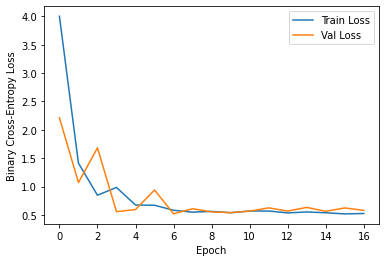

In [39]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-Entropy Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
             label='Val Loss')
    plt.legend()
    
plot_history(history)

- **Note**: according to the graph, we see that the losses for both the training set and the validation set are converging, which may mean that for the neural network model, it is being a model that generalizes well.

### 7.3. Evaluation

#### 7.3.1. Accuracy score
First, let's see the metrics of `accuracy score`.

- **Note**: The "`accuracy score`" is a performance metric used in machine learning and classification tasks. It calculates the proportion of correct predictions made by a model over the total number of predictions. It is a simple and commonly used way to assess how well a model is performing, especially when the classes are well-balanced.

In [40]:
# The accuracy of CatBoostClassifier is
y_predCB = model_CB.predict(X_train)
y_cv_predCB = model_CB.predict(X_cv)

y_predCB = y_predCB.astype(y_train.dtype)
y_cv_predCB = y_cv_predCB.astype(y_cv.dtype)

accuracy_trainCB = accuracy_score(y_train, y_predCB)
accuracy_cvCB = accuracy_score(y_cv, y_cv_predCB)

print(f"The accuracy for the training set was: {accuracy_trainCB}")
print(f"The accuracy for the validation set was: {accuracy_cvCB}")

The accuracy for the training set was: 0.505176876617774
The accuracy for the validation set was: 0.4974123059229442


Wow, that's look a little bad. Let's see how the network fares.

In [43]:
# The accuracy of Neural Network is
y_predNN = model_NN.predict(X_cv).flatten()

predictions = []
for prob in list(y_predNN):
    if prob >= 0.5:
        predictions.append(True)
    else:
        predictions.append(False)
        
y_predNN = pd.Series(predictions)

accuracy_NN = accuracy_score(y_cv, y_predNN)

print(f"The accuracy of the Neural Network was: {accuracy_NN}")

55/55 [==============================] - 0s 611us/step
The accuracy of the Neural Network was: 0.757906843013226


Looks better.

Apparently, the `neural network` actually **performs better** compared to `CatBoostClassifier`. So let's take a look at the `confusion matrix` to see if we can get some insight into the performances of both models.

#### 7.3.2. Confusion Matrix